In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np

# Load your dataset
data_files = {"train": "../../data_splits/train-data-split.csv", "test": "../../data_splits/test-data-split.csv"}
dataset = load_dataset("csv", data_files=data_files)

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Consumer complaint narrative', 'Product', 'Sub-product', 'Issue', 'Sub-issue'],
        num_rows: 185637
    })
    test: Dataset({
        features: ['Consumer complaint narrative', 'Product', 'Sub-product', 'Issue', 'Sub-issue'],
        num_rows: 61880
    })
})

In [4]:
issue_categories = np.unique(dataset['train']['Issue'])
issue_mapping = {k : i for i,k in enumerate(issue_categories)}

def encode_categories(batch):
    return {"labels": [issue_mapping[category] for category in batch['Issue']]}
    
dataset['train'] = dataset['train'].map(encode_categories , batched=True)
dataset['test'] = dataset['test'].map(encode_categories, batched=True)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Consumer complaint narrative', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'labels'],
        num_rows: 185637
    })
    test: Dataset({
        features: ['Consumer complaint narrative', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'labels'],
        num_rows: 61880
    })
})

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [7]:
def preprocess_function(examples):
    return tokenizer(examples["Consumer complaint narrative"], truncation=True, padding="max_length", max_length=512)

In [8]:
tokenized_data = dataset.map(preprocess_function, batched=True, remove_columns=['Product', 'Sub-product','Issue', 'Sub-issue'])

In [9]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['Consumer complaint narrative', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 185637
    })
    test: Dataset({
        features: ['Consumer complaint narrative', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 61880
    })
})

In [10]:
tokenized_data = tokenized_data.remove_columns('Consumer complaint narrative')

In [11]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 185637
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 61880
    })
})

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = {}

    metric_f1 = load_metric("f1")
    metric_precision = load_metric("precision")
    metric_recall = load_metric("recall")
    metric_acc = load_metric("accuracy")
    
    result["accuracy"] = metric_acc.compute(predictions = predictions, references = labels)["accuracy"]
    result["precision"] = metric_precision.compute(predictions = predictions, references = labels,average = 'macro')['precision']
    result["recall"] = metric_recall.compute(predictions = predictions, references = labels,average = 'macro')["recall"]
    result["f1"] = metric_f1.compute(predictions = predictions, references = labels, average = 'macro')["f1"]
    
    return result

In [14]:
id2label = {v : k for k,v in issue_mapping.items()}
label2id = issue_mapping

In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir="distil-bert-fintuned-issues-cfpb-complaints",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.726900,0.718676,0.743762,0.585285,0.532749,0.549084
2,0.612000,0.671110,0.765175,0.593483,0.557717,0.570207


/tmp/ipykernel_36934/3516474932.py:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_f1 = load_metric("f1")
/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/datasets/load.py:753: FutureWarning: The repository for precision contains custom code which must be executed to correc

TrainOutput(global_step=23206, training_loss=0.7534095095445665, metrics={'train_runtime': 4801.6859, 'train_samples_per_second': 77.322, 'train_steps_per_second': 4.833, 'total_flos': 4.919485725586022e+16, 'train_loss': 0.7534095095445665, 'epoch': 2.0})

In [20]:
predictions = trainer.predict(tokenized_data['test'])

/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/datasets/load.py:753: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code

In [21]:
trainer.push_to_hub("Mahesh9/distil-bert-fintuned-issues-cfpb-complaints")

CommitInfo(commit_url='https://huggingface.co/Mahesh9/distil-bert-fintuned-issues-cfpb-complaints/commit/1b9049731d062501f46cc35fa1e303d421c9dd30', commit_message='Mahesh9/distil-bert-fintuned-issues-cfpb-complaints', commit_description='', oid='1b9049731d062501f46cc35fa1e303d421c9dd30', pr_url=None, pr_revision=None, pr_num=None)

In [22]:
predicted_categories = np.argmax(predictions.predictions, axis=-1)
true_categories = [label2id[label] for label in dataset["test"]["Issue"]]

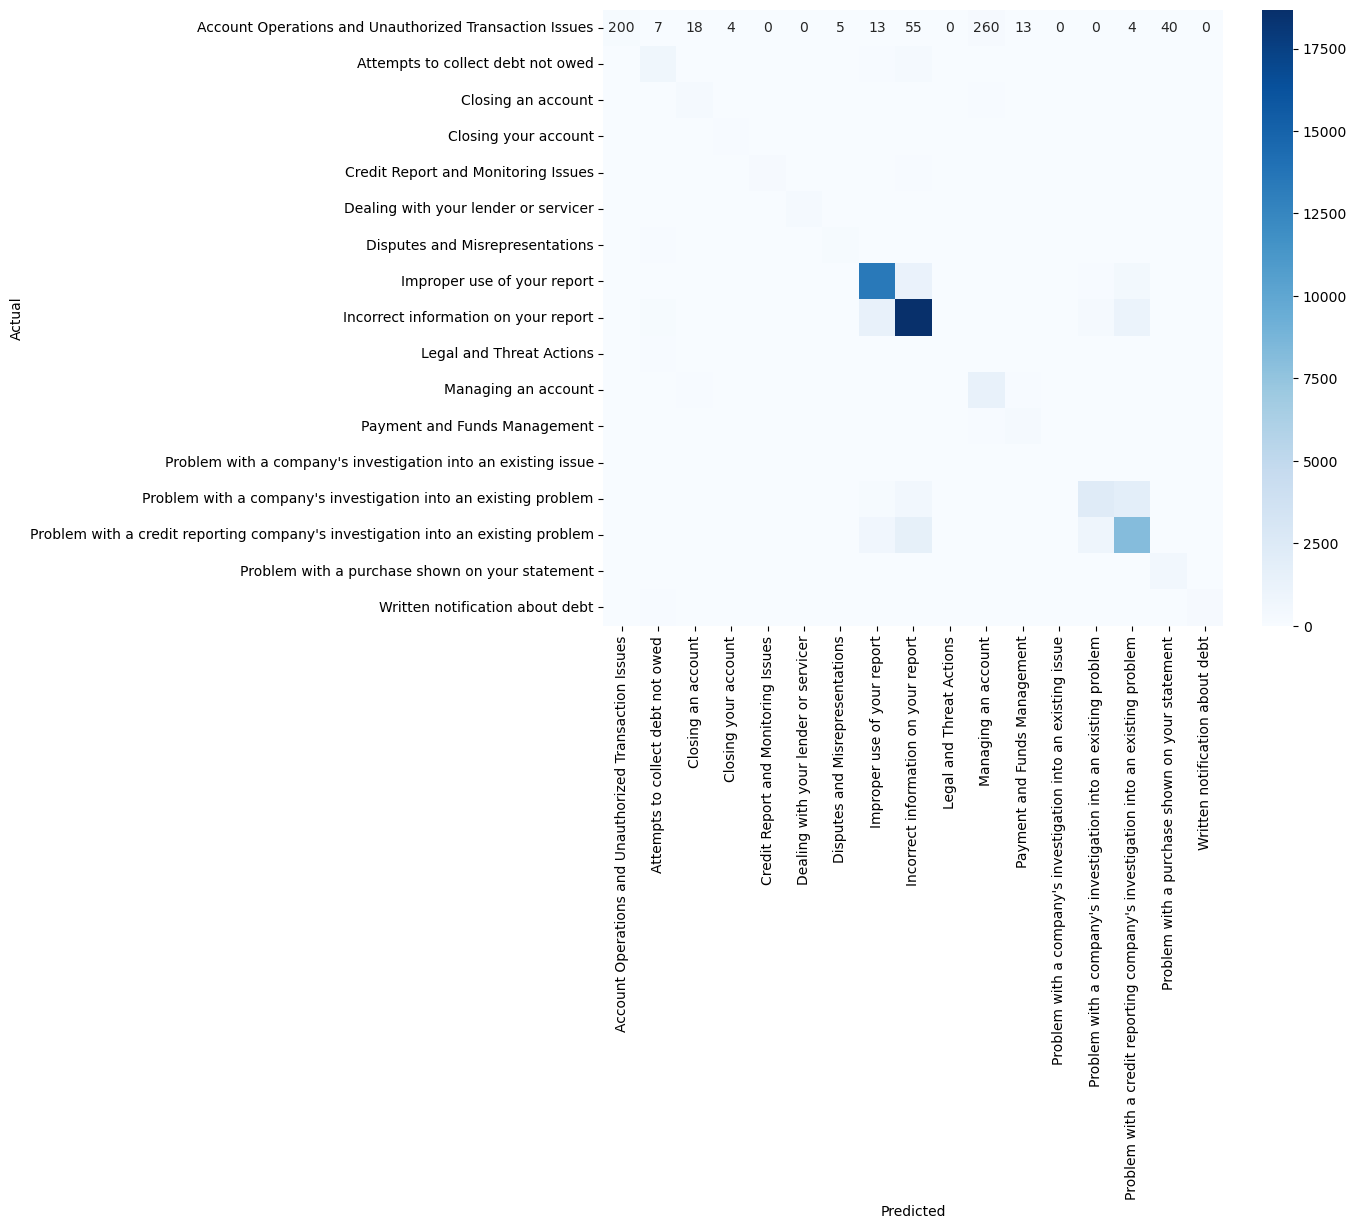

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust the confusion matrix call to work with numeric labels
cm = confusion_matrix(true_categories, predicted_categories, labels=list(id2label.keys()))

# Convert numeric labels back to category names for visualization
product_categories = list(id2label.values())

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=product_categories, yticklabels=product_categories)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
report = classification_report(true_categories, predicted_categories, target_names=product_categories)
print(report)

                                                                                  precision    recall  f1-score   support

                          Account Operations and Unauthorized Transaction Issues       0.56      0.32      0.41       619
                                               Attempts to collect debt not owed       0.54      0.57      0.56      1381
                                                              Closing an account       0.68      0.64      0.66       521
                                                            Closing your account       0.58      0.64      0.61       191
                                             Credit Report and Monitoring Issues       0.67      0.53      0.59       412
                                            Dealing with your lender or servicer       0.96      0.97      0.97       314
                                                 Disputes and Misrepresentations       0.50      0.38      0.43       550
                       

/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kudupudi.n/.conda/envs/pytorch_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [25]:
import pandas as pd

true_labels_text = [id2label[label] for label in true_categories]
predicted_labels_text = [id2label[label] for label in predicted_categories]

results_df = pd.DataFrame({
    'True Labels': true_labels_text,
    'Predicted Labels': predicted_labels_text
})

original_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in tokenized_data["test"]["input_ids"]]
results_df['Complaint Narrative'] = original_texts

In [26]:
results_df.to_csv('distil-bert-fintuned-issue-cfpb-complaints/saved_results/model_predictions_and_labels.csv', index=False)